In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [8]:
train = pd.read_csv("nlpdisastertweets/train.csv")
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


So there are some tweets in the "text" column, and some targets, based on whether they are disasters or not. We can do some feature engineering on like whether there's disaster keywords with # or whatever. We should do some EDA. 

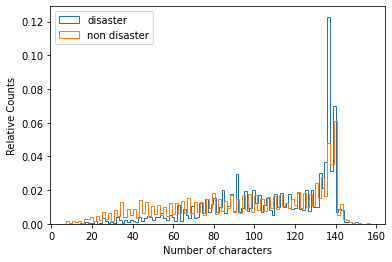

In [9]:
#Most obvious thing is tweet length. 
#I would expect that true disaster tweets are shorter, due to their immediate emergency status.
#Let's check
disastertweetlens = np.array([len(tweet) for tweet in train[train.target ==1].text], dtype = 'float32')
nondisastertweetlens = np.array([len(tweet) for tweet in train[train.target ==0].text], dtype = 'float32')

#Normalizing the histogram so that the y axis is relative frequency and the two can be directly compared.
#Obviously the max number of characters in a tweet is fixed at 160 so it's a moot point to adjust those.
disasterweights = np.ones_like(disastertweetlens)/float(len(disastertweetlens))
nondisasterweights = np.ones_like(nondisastertweetlens)/float(len(nondisastertweetlens))



plt.hist(disastertweetlens, histtype = 'step', label = 'disaster', weights = disasterweights, bins = 100)
plt.hist(nondisastertweetlens, histtype='step', label = 'non disaster', weights = nondisasterweights, bins = 100)
plt.xlabel("Number of characters")
plt.ylabel("Relative Counts")
plt.legend(loc = 2)
plt.show()



As it turns out, you cannot purely cut on the number of characters... However, it seems that non disaster tweets are not as verbose. Perhaps information about the distribution itself could be a thing to train on. Maybe density estimation??

In [10]:
#First we focus on how the punctuation plays a role... 
#Because you'd imagine people have different #blahblah usage or tagging
import string
print(string.punctuation)
#Let's check number of occurances of each character in the strings
punctuations = string.punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


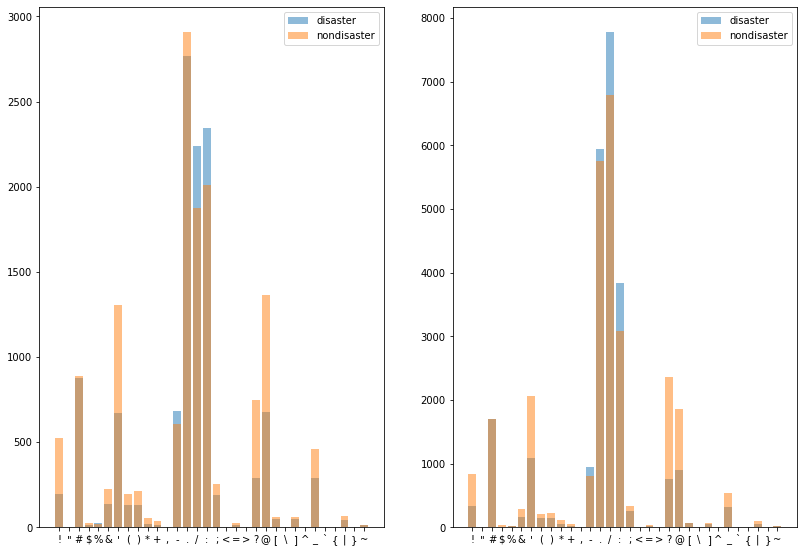

In [11]:
charsnondisaster = {}
charsnondisastercum = {}
for char in punctuations:
    count = 0
    countcum = 0
    for tweet in train[train.target == 0].text:
        if char in tweet:
            count += 1
        countcum += tweet.count(char)
    charsnondisaster[char] = count
    charsnondisastercum[char] = countcum

charsdisaster = {}
charsdisastercum = {}
for char in punctuations:
    count = 0
    countcum = 0
    for tweet in train[train.target == 1].text:
        if char in tweet:
            count += 1
        countcum += tweet.count(char)
    charsdisaster[char] = count
    charsdisastercum[char] = countcum


fig, ax = plt.subplots(1,2)
ax[0].bar(charsdisaster.keys(), [charsdisaster[key] for key in charsdisaster.keys()], label = 'disaster', alpha = 0.5)
ax[0].bar(charsnondisaster.keys(), [charsnondisaster[key] for key in charsnondisaster.keys()], label = 'nondisaster',alpha = 0.5)
ax[0].legend()

fig.tight_layout()
ax[1].bar(charsdisastercum.keys(), [charsdisastercum[key] for key in charsdisastercum.keys()], label = 'disaster', alpha = 0.5)
ax[1].bar(charsnondisastercum.keys(), [charsnondisastercum[key] for key in charsnondisastercum.keys()], label = 'nondisaster',alpha = 0.5)
ax[1].legend()
plt.subplots_adjust(left = 0.0001)
fig.set_size_inches(11, 8.5)

plt.show()

It is interesting that the use of "#" is the same in both disasters and nondisasters either way. People that use periods have more sentences in disasters than nondisasters. People seem to use multiple instances of "/" preferrentialy in disasters. There are some other insights as well. Time to check out the keywords and locations...

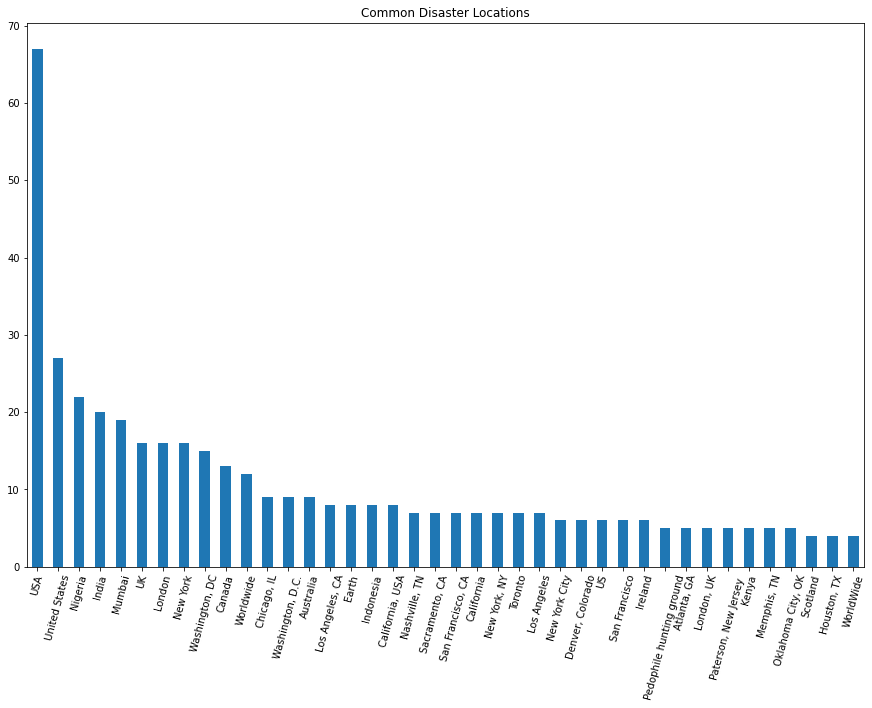

In [12]:
plt.figure(figsize = (15,10))
disasterlocs = train[train["target"]==1]["location"]
disasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Disaster Locations")
plt.show()

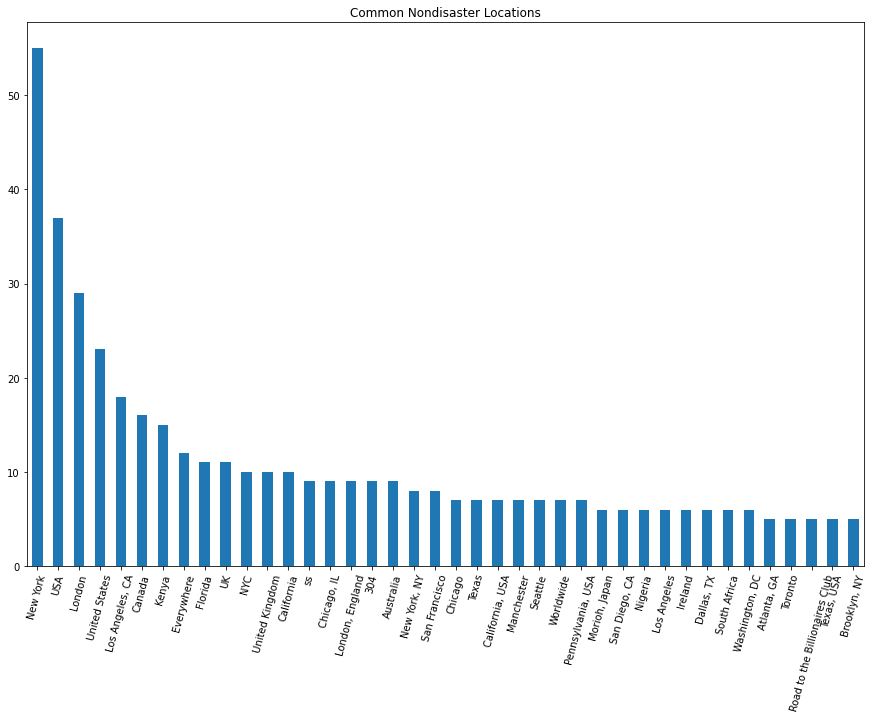

In [13]:
plt.figure(figsize = (15,10))
nondisasterlocs = train[train["target"]==0]["location"]
nondisasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Nondisaster Locations")
plt.show()

We'll do the same for the keywords

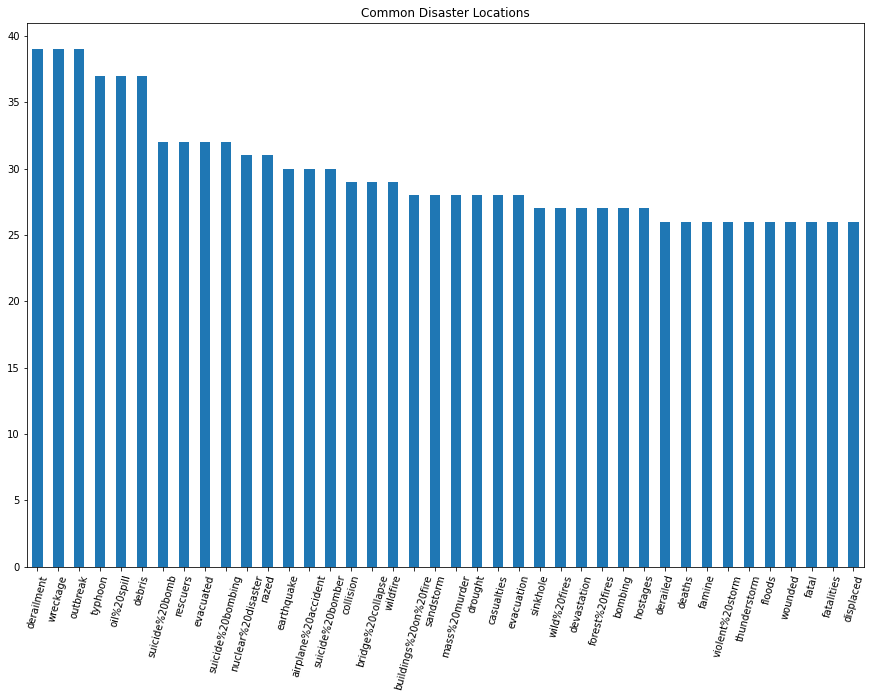

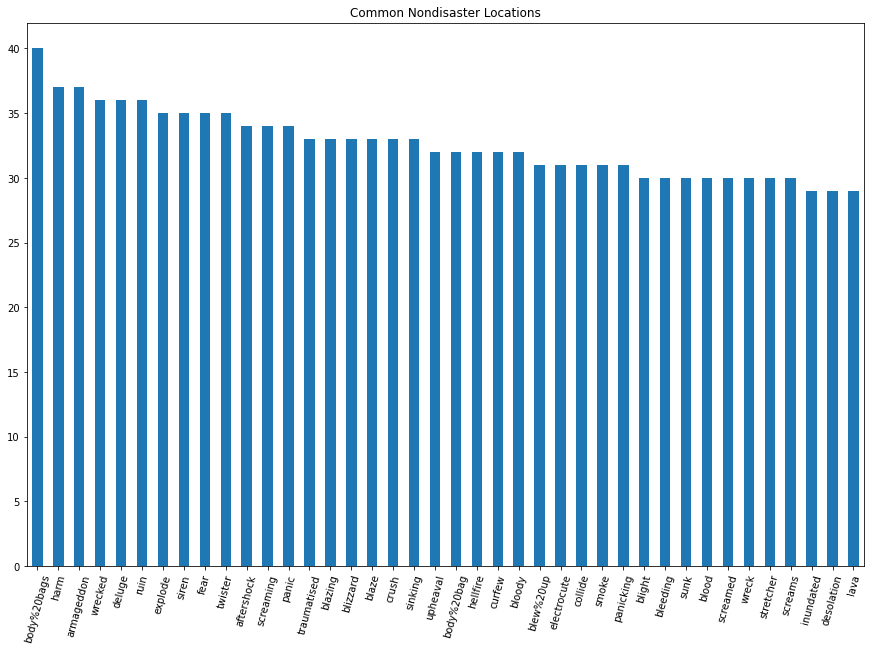

In [14]:
plt.figure(figsize = (15,10))
disasterlocs = train[train["target"]==1]["keyword"]
disasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Disaster Locations")
plt.show()

plt.figure(figsize = (15,10))
nondisasterlocs = train[train["target"]==0]["keyword"]
nondisasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Nondisaster Locations")
plt.show()

Now for some preprocessing. First thing is to remove tagged users, since the user who was tagged doesn't contain information about the text. Tags have @ in them. For #, remove the "#" since those don't contain information, only the actual hashtag does. Remove stopwords, since they contain little information. etc.

In [41]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re


def strip_prefixes(text):
    entity_prefixes = ['@']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def strip_stopwords(text):
    sw = set(stopwords.words("english"))
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in sw:
                words.append(word)
    return " ".join(words)

def strip_web(text):
    a = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text) #Removing stuff that has webpage looking strings
    b = re.sub(r'<.*?>',' ', a) #Removing HTML tags
    return b


def find_prefix(text, symbol):
    if text.__contains__(symbol):
        return 1
    else: 
        return 0


In [54]:
train['hashtags'] = train.text.apply(lambda x: find_prefix(x, "#"))
train['tags'] = train.text.apply(lambda x: find_prefix(x, "@"))
#Probably should group all the cleaning together, but this works well enough for now.
train['text_cleaned'] = train.text.apply(lambda x: strip_web(x))
train['text_cleaned'] = train.text_cleaned.apply(lambda x: x.lower())
train['text_cleaned'] = train.text_cleaned.apply(lambda x: strip_prefixes(x))
train['text_cleaned'] = train.text_cleaned.apply(lambda x: strip_stopwords(x))
train[:100]



,id,keyword,location,text,target,hashtags,tags,text_cleaned,text_stemmed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,0,reason earthquake forgive us,reason #earthquake forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,forest fire near la ronge canada,forest fire near la ronge canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,residents place being notified by no evacuatio...,residents 'shelter place' being notified by no...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,13 000 people receive wildfires evacuation cal...,"13,000 people receive #wildfires evacuation ca..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,0,just got photo from ruby from wildfires pours,just got photo from ruby #alaska from #wildfir...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,1,0,rockyfire update california hwy 20 closed both...,#rockyfire update => california hwy. 20 closed...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,1,0,flood heavy rain causes flash flooding colorado,#flood #disaster heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,0,0,hill can fire woods,hill can fire woods...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,0,0,emergency evacuation happening now building,emergency evacuation happening now build
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,0,0,coming,come


In [55]:
#Stemming because it's nearly as good as lemmatizing, without need for linguistics...
stemmer = PorterStemmer()
train['text_stemmed'] = train.text_cleaned.apply(lambda x: stemmer.stem(x))
train[:100]

,id,keyword,location,text,target,hashtags,tags,text_cleaned,text_stemmed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,0,reason earthquake forgive us,reason earthquake forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,forest fire near la ronge canada,forest fire near la ronge canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,residents place being notified by no evacuatio...,residents place being notified by no evacuatio...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,13 000 people receive wildfires evacuation cal...,13 000 people receive wildfires evacuation cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,0,just got photo from ruby from wildfires pours,just got photo from ruby from wildfires pour
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,1,0,rockyfire update california hwy 20 closed both...,rockyfire update california hwy 20 closed both...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,1,0,flood heavy rain causes flash flooding colorado,flood heavy rain causes flash flooding colorado
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,0,0,hill can fire woods,hill can fire wood
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,0,0,emergency evacuation happening now building,emergency evacuation happening now build
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,0,0,coming,come


In [ ]:
#Data has been preprocessed. We'll do some machine learning and then see if it needs more preprocessing or whatever.

